# Exploratory Data Analysis

This notebook contains the code for exploratory data analysis. It will focus on extracting data from the replays as a whole. The following steps will be followed:
1. Create a list of all replays with a relative link to their files.
    * Replays will be identified by their filehash, duplicate filehashes will not be added to the list.
    * First create the table as a pandas dataframe, after which it can be written to csv.
    * The list will be saved in the root of the `data/` folder, and this will be used as the reference point for relative file paths.
    * Only 1v1 replays will be considered. This will be confirmed from the `game_type` attribute.
2. Extract relevant data from replay files. The following data will be extracted:
    * Map
    * Player names
    * Player races
    * Player levels (if available)
    * Player highest league (if available)
    * Date
    * Length
    * Winner
3. Add all relevant data to the csv
4. Data exploration
    * Initial data visualization.
    * Cleaning any missing data.
5. Initial modeling of metadata to observe any interesting trends.

In [1]:
# initial imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sc2reader
import re
import random
import datetime
import json
from scripts.classes import ReplayInfo
import time

# sklearn
from sklearn.metrics import confusion_matrix

In [2]:
#### Matplotlib settings
%matplotlib inline
import matplotlib as mpl

# specify default rcParams so that fontsize, weight and style do not need to set
# each time
# Title in bold, fontsize 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 20
# Plot fontsize 12 and bold
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 13
# set figure size
mpl.rcParams['figure.figsize'] = (15, 8)

# race list and colors that will be used to represent them
RACE_LIST = [
    'Protoss',
    'Terran',
    'Zerg'
    ]
COLOR_DICT = {
    'Protoss': 'goldenrod',
    'Terran': 'firebrick',
    'Zerg': 'darkviolet'
    }

## Data Cleaning
Begin data cleaning by removing all replays:
* that are not 1v1.
* without a winner.
* with a length of less than 5 or more than 60 minutes.
* with invalid player races.
* with invalid player mmrs.
* where game_speed not Faster.
* where is_lader is not True.
* where fps is not 16.
* where region is not 'eu', 'us', 'cn', kr'

In [3]:
# load replay_df from csv
replay_df = pd.read_csv('data/replays.csv')
display(replay_df.head())
replay_df.info()

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region
0,C:/Users/jared/Gits/sc2-modeling/data/replays/...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Protoss,Zerg,5402,5564,932,1v1,Faster,2,1502208724,16.0,True,eu
1,C:/Users/jared/Gits/sc2-modeling/data/replays/...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Terran,Terran,3882,3951,324,1v1,Faster,1,1502197141,16.0,True,eu
2,C:/Users/jared/Gits/sc2-modeling/data/replays/...,be0af789b8cef0379fd32602b5730096bb0b0138fe7aba...,Terran,Zerg,4088,3365,667,1v1,Faster,2,1502280613,16.0,True,eu
3,C:/Users/jared/Gits/sc2-modeling/data/replays/...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Zerg,Terran,3234,3063,775,1v1,Faster,1,1502262699,16.0,True,cn
4,C:/Users/jared/Gits/sc2-modeling/data/replays/...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Zerg,Zerg,4254,4121,537,1v1,Faster,1,1502290022,16.0,True,us


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225045 entries, 0 to 1225044
Data columns (total 14 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   filename      1225045 non-null  object 
 1   map           1225045 non-null  object 
 2   player1_race  1159369 non-null  object 
 3   player2_race  1159369 non-null  object 
 4   player1_mmr   1225045 non-null  int64  
 5   player2_mmr   1225045 non-null  int64  
 6   game_length   1225045 non-null  int64  
 7   game_type     1225045 non-null  object 
 8   game_speed    1225045 non-null  object 
 9   game_winner   1225045 non-null  int64  
 10  timestamp     1225045 non-null  int64  
 11  fps           1225045 non-null  float64
 12  is_ladder     1225045 non-null  bool   
 13  region        1225045 non-null  object 
dtypes: bool(1), float64(1), int64(5), object(7)
memory usage: 122.7+ MB


In [4]:
def clean_replay_df(df):
    """
    clean_replay_df
    Clean the df by removing duplicates and removing rows with missing
    values

    Args:
        df (pd.DataFrame): DataFrame to be cleaned

    Returns:
        pd.DataFrame: Cleaned DataFrame
    """

    # remove duplicates
    df = df.drop_duplicates()

    # remove rows with missing values
    df = df.dropna()

    # remove replays that are not 1v1
    df = df[df['game_type'] == '1v1']
    
    # remove replays without a winner
    df = df[df['game_winner'] != 0]
    # rename game_winner to winner
    df = df.rename(columns={'game_winner':'winner'})

    # remove replays with a game length of 5 or longer than 60 minutes
    df = df[
        (df['game_length'] > 0) 
        & (df['game_length'] < 3600)
        ]

    # remove replays with invalid player races
    df = df[df['player1_race'].isin(RACE_LIST)]
    df = df[df['player2_race'].isin(RACE_LIST)]

    # remove replays with invalid player mmrs
    valid_mmr_range = (3000, 7000)
    # keep replays where both player mmr between valid_mmr_range[0] and [1]
    df = df[
        (df['player1_mmr'] >= valid_mmr_range[0]) 
        & (df['player1_mmr'] <= valid_mmr_range[1])
        & (df['player2_mmr'] >= valid_mmr_range[0])
        & (df['player2_mmr'] <= valid_mmr_range[1])
        ]

    # remove replays with invalid game speed
    df = df[df['game_speed'] == 'Faster']

    # remove replays where is_ladder is not True
    df = df[df['is_ladder'] == True]

    # remove replays where region is not valid
    valid_regions = ['us', 'eu', 'kr', 'cn']
    df = df[df['region'].isin(valid_regions)]

    # convert timestamp from unix timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    return df.reset_index(drop=True)



In [5]:
replay_df = clean_replay_df(replay_df)
display(replay_df.head())
replay_df.info()

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,winner,timestamp,fps,is_ladder,region
0,C:/Users/jared/Gits/sc2-modeling/data/replays/...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Protoss,Zerg,5402,5564,932,1v1,Faster,2,2017-08-08 16:12:04,16.0,True,eu
1,C:/Users/jared/Gits/sc2-modeling/data/replays/...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Terran,Terran,3882,3951,324,1v1,Faster,1,2017-08-08 12:59:01,16.0,True,eu
2,C:/Users/jared/Gits/sc2-modeling/data/replays/...,be0af789b8cef0379fd32602b5730096bb0b0138fe7aba...,Terran,Zerg,4088,3365,667,1v1,Faster,2,2017-08-09 12:10:13,16.0,True,eu
3,C:/Users/jared/Gits/sc2-modeling/data/replays/...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Zerg,Terran,3234,3063,775,1v1,Faster,1,2017-08-09 07:11:39,16.0,True,cn
4,C:/Users/jared/Gits/sc2-modeling/data/replays/...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Zerg,Zerg,4254,4121,537,1v1,Faster,1,2017-08-09 14:47:02,16.0,True,us


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916245 entries, 0 to 916244
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   filename      916245 non-null  object        
 1   map           916245 non-null  object        
 2   player1_race  916245 non-null  object        
 3   player2_race  916245 non-null  object        
 4   player1_mmr   916245 non-null  int64         
 5   player2_mmr   916245 non-null  int64         
 6   game_length   916245 non-null  int64         
 7   game_type     916245 non-null  object        
 8   game_speed    916245 non-null  object        
 9   winner        916245 non-null  int64         
 10  timestamp     916245 non-null  datetime64[ns]
 11  fps           916245 non-null  float64       
 12  is_ladder     916245 non-null  bool          
 13  region        916245 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(7)
memor

## Data Exploration

### Count the number of wins per race

In [6]:
# add a column for the winning race
# if winner is 1 record player1_race else record player2_race
def winning_race(row):
    if row['winner'] == 1:
        return row['player1_race']
    else:
        return row['player2_race']

replay_df['winning_race'] = replay_df.apply(
    lambda row: winning_race(row), 
    axis=1
    )

replay_df.head()

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,winner,timestamp,fps,is_ladder,region,winning_race
0,C:/Users/jared/Gits/sc2-modeling/data/replays/...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Protoss,Zerg,5402,5564,932,1v1,Faster,2,2017-08-08 16:12:04,16.0,True,eu,Zerg
1,C:/Users/jared/Gits/sc2-modeling/data/replays/...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Terran,Terran,3882,3951,324,1v1,Faster,1,2017-08-08 12:59:01,16.0,True,eu,Terran
2,C:/Users/jared/Gits/sc2-modeling/data/replays/...,be0af789b8cef0379fd32602b5730096bb0b0138fe7aba...,Terran,Zerg,4088,3365,667,1v1,Faster,2,2017-08-09 12:10:13,16.0,True,eu,Zerg
3,C:/Users/jared/Gits/sc2-modeling/data/replays/...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Zerg,Terran,3234,3063,775,1v1,Faster,1,2017-08-09 07:11:39,16.0,True,cn,Zerg
4,C:/Users/jared/Gits/sc2-modeling/data/replays/...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Zerg,Zerg,4254,4121,537,1v1,Faster,1,2017-08-09 14:47:02,16.0,True,us,Zerg


<Figure size 1080x576 with 0 Axes>

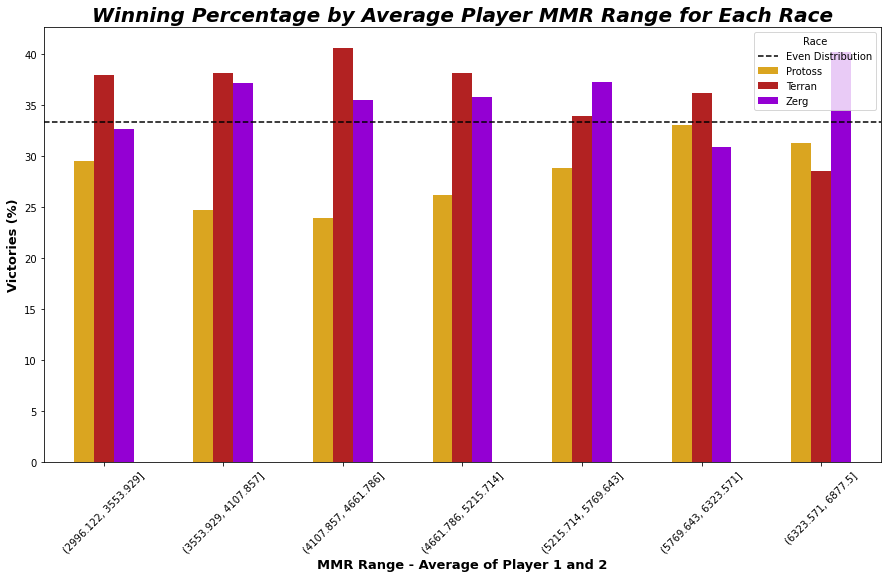

In [7]:
# create summary table of winning_race binned by average player mmr
bins = 7

# add average mmr column
replay_df['average_mmr'] = replay_df[
    ['player1_mmr', 'player2_mmr']
    ].mean(axis=1)

# divide mmr range into 10 bins
df_bins = pd.cut(replay_df['average_mmr'], bins=bins)

# group by df_bins
grouped_df = replay_df.groupby(df_bins)['winning_race'].value_counts().unstack()

# calculate each column as fraction of row total
grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0).multiply(100)

# plot 
plt.figure()
grouped_df.plot(kind='bar', rot=45, color=COLOR_DICT)
# plot dotted line for 1/3
plt.axhline(y=100/3, color='k', linestyle='--', label='Even Distribution')
plt.ylabel('Victories (%)')
plt.xlabel('MMR Range - Average of Player 1 and 2')
plt.title(
    'Winning Percentage by Average Player MMR Range for Each Race',
    style='italic'
    )
plt.legend(title='Race', fancybox=True)
plt.show()

<Figure size 1080x576 with 0 Axes>

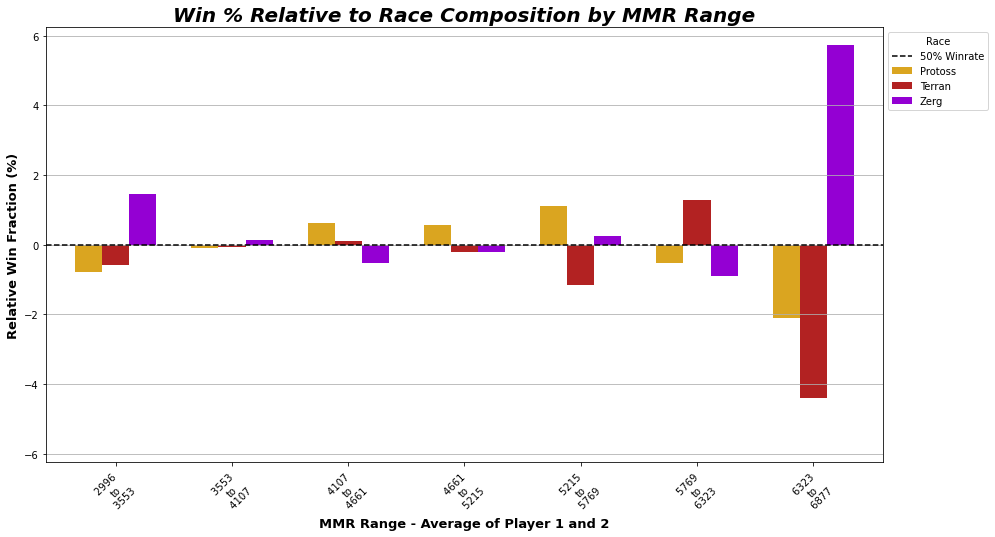

In [8]:
players_df = replay_df.groupby(df_bins)[
    'player1_race'].value_counts().unstack()

players_df += replay_df.groupby(df_bins)[
    'player2_race'].value_counts().unstack()

# group by df_bins
grouped_df = replay_df.groupby(df_bins)['winning_race'].value_counts().unstack()

for col in grouped_df:
    grouped_df[col] = (grouped_df[col] / players_df[col])*100 - 50

# plot 
plt.figure()
ax = grouped_df.plot(
    kind='bar',
    rot=45, 
    color=COLOR_DICT,
    width=0.7)

# plot dotted line for 1/3
plt.axhline(y=0, color='k', linestyle='--', label='50% Winrate')
plt.ylabel('Relative Win Fraction (%)')
plt.xlabel('MMR Range - Average of Player 1 and 2')
plt.title(
    'Win % Relative to Race Composition by MMR Range',
    style='italic'
    )
# set ylims to be symmetric around 0
max_y = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-max_y, ymax=max_y)
x_labels = [f'{int(x.left)} \nto\n {int(x.right)}' for x in grouped_df.index]
ax.set_xticklabels(x_labels, ha='center')
# place legend outside of plot
plt.legend(
    title='Race',
    fancybox=True,
    bbox_to_anchor=(1,1),
    loc='upper left')
# gridlines for y axis only
plt.grid(axis='y')
plt.show()


## Data Wrangling

Here we will:
* convert maphash to an index value.
* convert categorical columns to dummy variables.
* convert game_winner to a binary variable stating if player 1 won or not.
* keep only informative columns:
    * `winner`
    * `map`
    * `game_length`
    * `region`
    * `player1_race`
    * `player2_race`
    * `player1_mmr`
    * `player2_mmr`
* use player1 and 2 mmr to calculate player1 mmr advantage (i.e., player1 mmr - player2 mmr)

In [9]:
def wrangle_data(df):
    """
    wrangle_data
    Wrangle the df to create a dataframe with features and labels.
    Drop any unnecessary columns.

    Args:
        df (pd.DataFrame): DataFrame to be wrangled

    Returns:
        pd.DataFrame: Wrangled DataFrame
    """

    # list of columns we intend to keep
    keep_list = [
        'winner',
        'map',
        'game_length',
        'region',
        'player1_race',
        'player2_race',
        'player1_mmr',
        'player2_mmr'
        ]

    # drop all columns not in keep_list
    df = df[keep_list].copy()

    # convert maphash to an a more legible string
    maphash_converter = {}
    for i, maphash in enumerate(df['map'].unique()):
        maphash_converter[maphash] = 'map_' + str(i+1)

    df['map'] = df['map'].map(maphash_converter).copy()

    # convert winner to a binary value
    df['winner'] = df['winner'].map({1:1, 2:0}).copy()

    # convert region, player1_race and player2_race into dummies
    dummy_list = ['region', 'player1_race', 'player2_race', 'map']
    prefix_list = ['region', 'player1', 'player2', 'map']
    df = pd.get_dummies(
        df,
        prefix=prefix_list,
        columns=dummy_list,
        drop_first=True
        )

    # calculate the difference in mmr between the two players
    df['mmr_diff'] = df['player1_mmr'] - df['player2_mmr']

    # drop player1_mmr and player2_mmr
    df = df.drop(['player1_mmr', 'player2_mmr'], axis=1)

    return df

In [10]:
clean_df = wrangle_data(replay_df)
display(clean_df.head())
clean_df.info()

,winner,game_length,region_eu,region_kr,region_us,player1_Terran,player1_Zerg,player2_Terran,player2_Zerg,map_map_2,map_map_3,map_map_4,map_map_5,map_map_6,map_map_7,map_map_8,map_map_9,mmr_diff
0,0,932,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-162
1,1,324,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,-69
2,0,667,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,723
3,1,775,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,171
4,1,537,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,133


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916245 entries, 0 to 916244
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   winner          916245 non-null  int64
 1   game_length     916245 non-null  int64
 2   region_eu       916245 non-null  uint8
 3   region_kr       916245 non-null  uint8
 4   region_us       916245 non-null  uint8
 5   player1_Terran  916245 non-null  uint8
 6   player1_Zerg    916245 non-null  uint8
 7   player2_Terran  916245 non-null  uint8
 8   player2_Zerg    916245 non-null  uint8
 9   map_map_2       916245 non-null  uint8
 10  map_map_3       916245 non-null  uint8
 11  map_map_4       916245 non-null  uint8
 12  map_map_5       916245 non-null  uint8
 13  map_map_6       916245 non-null  uint8
 14  map_map_7       916245 non-null  uint8
 15  map_map_8       916245 non-null  uint8
 16  map_map_9       916245 non-null  uint8
 17  mmr_diff        916245 non-null  int64
dtypes: i

## Modeling

Attempt using a logistic model to predict victory based on cleaned metadata.


In [11]:
del replay_df

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# import svm
from sklearn.svm import SVC

# import random forest
from sklearn.ensemble import RandomForestClassifier

# import KNN
from sklearn.neighbors import KNeighborsClassifier

# import grid_search
from sklearn.model_selection import GridSearchCV

# import warnings
import warnings

# suppress warnings
warnings.filterwarnings('ignore')

In [13]:
# do test train split
X_train, X_test, y_train, y_test = train_test_split(
    clean_df.drop('winner', axis=1),
    clean_df['winner'],
    test_size=0.2,
    random_state=42,
    stratify=clean_df['winner']
)


In [ ]:

# use grid search to find best model
classifiers = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    KNeighborsClassifier()
]

best_models = {}

parameters = [{
        'LogisticRegression__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
        'LogisticRegression__penalty': ['l1', 'l2'],
        'LogisticRegression__solver': ['saga', 'newton-cg', 'lbfgs']
    },
    {
        'SVC__C': [0.00001, 0.001, 0.01, 1],
        'SVC__kernel': ['rbf', 'poly', 'sigmoid'],
    },
    {
        'RandomForestClassifier__n_estimators': [10, 30, 40, 60, 70, 100],
        'RandomForestClassifier__max_depth': [2, 5, 6, 8, 10],
    },{
        'KNeighborsClassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]
    }
]

# loop through classifiers performing grid search
for i, classifier in enumerate(classifiers):

    # classifier name
    classifier_name = classifier.__class__.__name__
    # start timer
    timer = time.time()

    print(f'Testing {classifier_name}')
    print('____________________________________________')

    # create pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        (classifier_name, classifier)
    ])

    grid_search = GridSearchCV(
        pipe,
        param_grid=parameters[i],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
        )

    grid_search.fit(X_train, y_train)

    # store best model object
    best_models[classifier_name] = grid_search.best_estimator_

    print(f'Best parameters for {classifier_name}:')
    print(grid_search.best_params_)
    print(f'Best score for {classifier_name}:')
    print(f'{round(grid_search.best_score_*100,2)}%')
    print(f'Best estimator for {classifier_name}:')
    print(grid_search.best_estimator_)
    print(f'Test took {round(time.time() - timer, 1)} seconds')
    print(
'_____________________________________________________________________________')

In [14]:
# test single svc model
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=0.1, kernel='rbf', verbose=True))
])

# fit the model
pipe.fit(X_train, y_train)

# predict on training data
y_pred = pipe.predict(X_train)

# score the model
print(f'Training accuracy: {round(pipe.score(X_train, y_train)*100, 2)}%')
print(f'Training confusion matrix:')
pd.DataFrame(
    confusion_matrix(y_train, y_pred),
    index=['lose_pred', 'win_pred'],
    columns=['lose_actual', 'win_actual']
).T.style.background_gradient()



[LibSVM]

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(f'Training precision: {round(precision_score(y_train, y_pred)*100, 2)}%')
print(f'Training recall: {round(recall_score(y_train, y_pred)*100, 2)}%')
print(f'Training F1 score: {round(f1_score(y_train, y_pred)*100, 2)}%')